<img align="center" src="https://iili.io/3wI8gI.png" style="height:90px" style="width:30px"/>

<h1><center>Canceled bookings at a hotel</center></h1>

<hr style="border:3px solid pink"> </hr>



You have been assigned the task of building a model that will predict whether or not a customer of a hotel will cancel their booking. The data for this assingment is found in the csv file `hotel_clf`

<br> 
<div>
<img src="https://5.imimg.com/data5/PC/BL/MY-33192851/hotel-reservation-services-500x500.jpg" width="400"/>
</div>
<br> 
If the model predicts that a customer will cancel their booking, that customer will be sent a special deal to try to keep the customer from cancel the booking. If the prediction is correct (a True Positive), the expected gain is 1000 SEK. However, if the prediction is wrong (a False Positive), the expected loss is 500 SEK. 

Your goal is to build the most profitable model possible.


<hr style="border:3px solid pink"> </hr>

Instructions for train test split:

- Test size = 0.2
- Random state = 42

https://www.kaggle.com/datasets/jessemostipak/hotel-booking-demand
https://www.kaggle.com/code/niteshyadav3103/hotel-booking-prediction-99-5-acc

In [265]:
# Libraries
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Surpress future warnings
import warnings
warnings.filterwarnings(category=FutureWarning, action='ignore')

pd.options.display.max_columns = 100

df = pd.read_csv('hotel_bookings.csv')
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119390 entries, 0 to 119389
Data columns (total 32 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   hotel                           119390 non-null  object 
 1   is_canceled                     119390 non-null  int64  
 2   lead_time                       119390 non-null  int64  
 3   arrival_date_year               119390 non-null  int64  
 4   arrival_date_month              119390 non-null  object 
 5   arrival_date_week_number        119390 non-null  int64  
 6   arrival_date_day_of_month       119390 non-null  int64  
 7   stays_in_weekend_nights         119390 non-null  int64  
 8   stays_in_week_nights            119390 non-null  int64  
 9   adults                          119390 non-null  int64  
 10  children                        119386 non-null  float64
 11  babies                          119390 non-null  int64  
 12  meal            

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,0.0,0,BB,PRT,Direct,Direct,0,0,0,C,C,3,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,0.0,0,BB,PRT,Direct,Direct,0,0,0,C,C,4,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,0.0,0,BB,GBR,Direct,Direct,0,0,0,A,C,0,No Deposit,NaN,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,0.0,0,BB,GBR,Corporate,Corporate,0,0,0,A,A,0,No Deposit,304.0,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,0.0,0,BB,GBR,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,240.0,NaN,0,Transient,98.0,0,1,Check-Out,2015-07-03


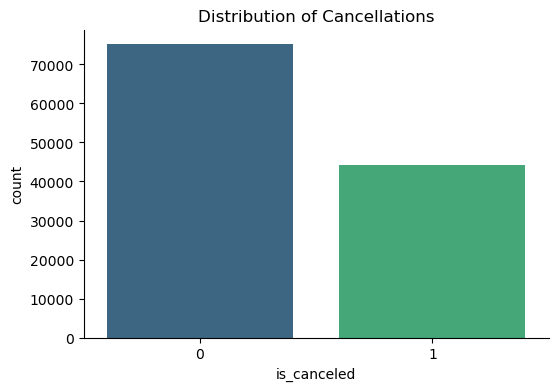

In [266]:
# Distribution of Target Variable (Class Balance)
plt.figure(figsize=(6, 4))
sns.countplot(x='is_canceled', data=df, palette='viridis')
plt.title('Distribution of Cancellations')
sns.despine()

## Data Cleaning

In [267]:
# Initial setup for nicer formatting
print("\nData Cleaning Report")
print("--------------------")

# Step 1: Reporting and Dropping the 'company' column due to irrelevance (being an ID) and missing values
if 'company' in df.columns:
    missing_values_company = df['company'].isnull().sum()
    print(f"\nStep 1: 'company' column has {missing_values_company} missing values, representing a significant portion of the dataset. Dropping 'company' column due to its high number of missing values.")
    df = df.drop(columns=['company'])
else:
    print("\nStep 1: 'company' column not found in the dataset.")

# Step 2: Impute missing values for 'agent' and 'country'
df['agent'] = df['agent'].fillna(0)  # Replacing missing 'agent' values with 0
df['country'] = df['country'].fillna('Unknown')  # Replacing missing 'country' values with 'Unknown'
print("\nStep 2: Imputed missing values for 'agent' with 0 and for 'country' with 'Unknown'.")

# Step 3: Drop rows with missing values in other features and calculate the impact
rows_before_drop = len(df)
df.dropna(inplace=True)
rows_dropped = rows_before_drop - len(df)
percentage_dropped = (rows_dropped / rows_before_drop) * 100
print(f"\nStep 3: Summary of Rows Dropped due to missing values in other features:\nNumber of rows dropped: {rows_dropped} ({percentage_dropped:.3f}% of the dataset)")

# Step 4: Drop duplicate rows
rows_dropped = df.duplicated().sum()
df.drop_duplicates(inplace=True)
print(f"\nStep 4: Dropped {rows_dropped} duplicates, remaining: {len(df)}/{rows_before_drop} rows.")

# Step 5: Remove rows with low cardinality
# Adjust the logic for calculating dropped rows due to low cardinality
df_filtered = df[~df['reserved_room_type'].isin(['L', 'P']) & (df['distribution_channel'] != 'Undefined')]
low_cardinality_rows_dropped = len(df) - len(df_filtered)
df = df_filtered
print(f"\nStep 5: Removed {low_cardinality_rows_dropped} rows due to low cardinality in 'reserved_room_type' and 'distribution_channel'.")

# Step 6: Consolidate sparse categories in 'country'
less_than_10 = df['country'].value_counts()[df['country'].value_counts() < 10].index
df.loc[df['country'].isin(less_than_10), 'country'] = 'Other'
print(f"\nStep 6: {len(less_than_10)} countries were categorized as 'Other'.")
#print("\nUpdated country value counts:")
#print(df['country'].value_counts())


Data Cleaning Report
--------------------

Step 1: 'company' column has 112593 missing values, representing a significant portion of the dataset. Dropping 'company' column due to its high number of missing values.

Step 2: Imputed missing values for 'agent' with 0 and for 'country' with 'Unknown'.

Step 3: Summary of Rows Dropped due to missing values in other features:
Number of rows dropped: 4 (0.003% of the dataset)

Step 4: Dropped 32001 duplicates, remaining: 87385/119390 rows.

Step 5: Removed 13 rows due to low cardinality in 'reserved_room_type' and 'distribution_channel'.

Step 6: 83 countries were categorized as 'Other'.


## EDA

### Generating a Profiling Report with ydata-profiling

Utilize `ydata-profiling` to generate an in-depth profiling report of the dataset. The report includes comprehensive analyses such as descriptive statistics, correlations, and more, enhancing understanding of the data's structure and relationships. The report can be viewed directly in the notebook or saved as an HTML file for further examination.

In [268]:
# # Library
# from ydata_profiling import ProfileReport

# profile = ProfileReport(
#     df=df,
#     title='Profiling Report',
#     html={"style": {"full_width": True}},
#     minimal=False,
#     correlations={
#         "pearson": {"calculate": True},
#         "spearman": {"calculate": True},
#         "kendall": {"calculate": True},
#         "phi_k": {"calculate": True},
#         "cramers": {"calculate": True},
#     },
# )

# #profile.to_widgets()
# #profile.to_file("profiling_report.html")
# profile.to_notebook_iframe()

### Guest Country of Origin
A visual representation of guest nationalities, followed by a table identifying countries with the highest cancellation rates.

In [269]:
import folium
from folium.plugins import HeatMap
import plotly.express as px

country_wise_guests = df[df['is_canceled'] == 0]['country'].value_counts().reset_index()
country_wise_guests.columns = ['country', 'No of guests']

basemap = folium.Map()
guests_map = px.choropleth(country_wise_guests, locations = country_wise_guests['country'],
                           color = country_wise_guests['No of guests'], hover_name = country_wise_guests['country'])
guests_map.show()

In [270]:
# Top N countries with the highest frequency of bookings
top_countries = df['country'].value_counts().nlargest(10).index.tolist()

# Filter the DataFrame to include only the top N countries
df_filtered = df[df['country'].isin(top_countries)]

# Create a contingency table
contingency_table = pd.crosstab(df_filtered['country'], df_filtered['is_canceled'], normalize='index') * 100

# Find the maximum percentage of is_canceled being 1
max_percent_canceled = contingency_table[1].max()

print("Percentage of Cancellations by Country")

(contingency_table
 .sort_values(by=1, ascending=False)
 .style
 .background_gradient(cmap='RdBu_r', subset=[1], vmax=max_percent_canceled)
)


Percentage of Cancellations by Country


is_canceled,0,1
country,,
BRA,63.558897,36.441103
PRT,64.340125,35.659875
ITA,64.938030,35.061970
ESP,74.324324,25.675676
IRL,77.851459,22.148541
BEL,80.249880,19.750120
FRA,80.389272,19.610728
DEU,80.452942,19.547058
GBR,80.972009,19.027991


#### Monthly Cancellation Trends
The data suggests a notable trend in July and August, indicating it as a potential predictor of booking cancellations.

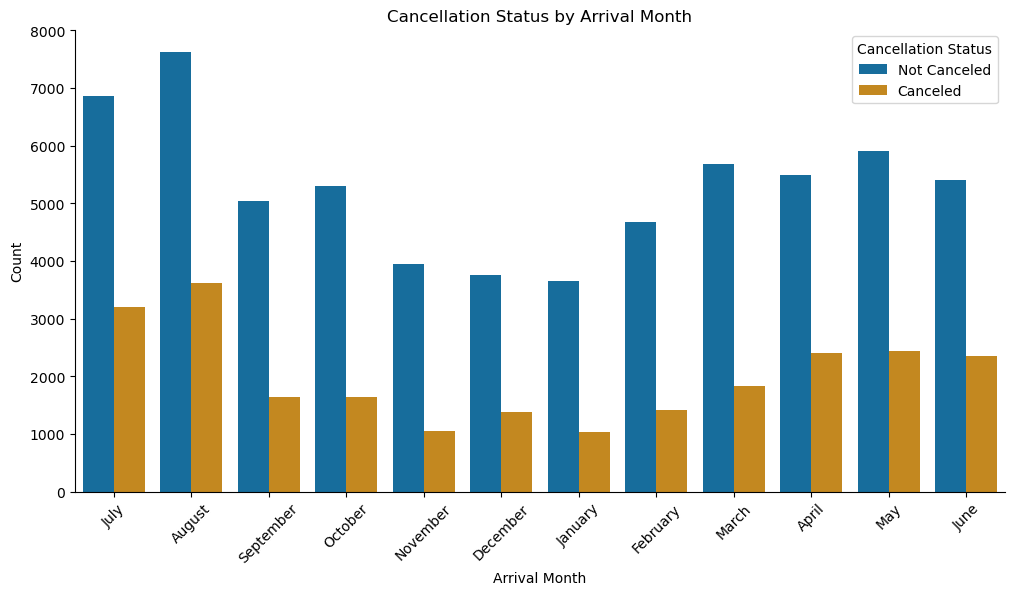

In [271]:
# Plotting
sns.set_palette('colorblind')
plt.figure(figsize=(12, 6))
sns.countplot(data=df, x='arrival_date_month', hue='is_canceled', order=df['arrival_date_month'].unique())
plt.title('Cancellation Status by Arrival Month')
plt.xlabel('Arrival Month')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.legend(title='Cancellation Status', labels=['Not Canceled', 'Canceled'])
sns.despine()

### Correlating Features

#### Numerical
- Moderate correlation between `stays_in_weekend_nights` and `stays_in_week_nights`
- Moderate correlation between `arrival_date_week_number` and `arrival_date_year`

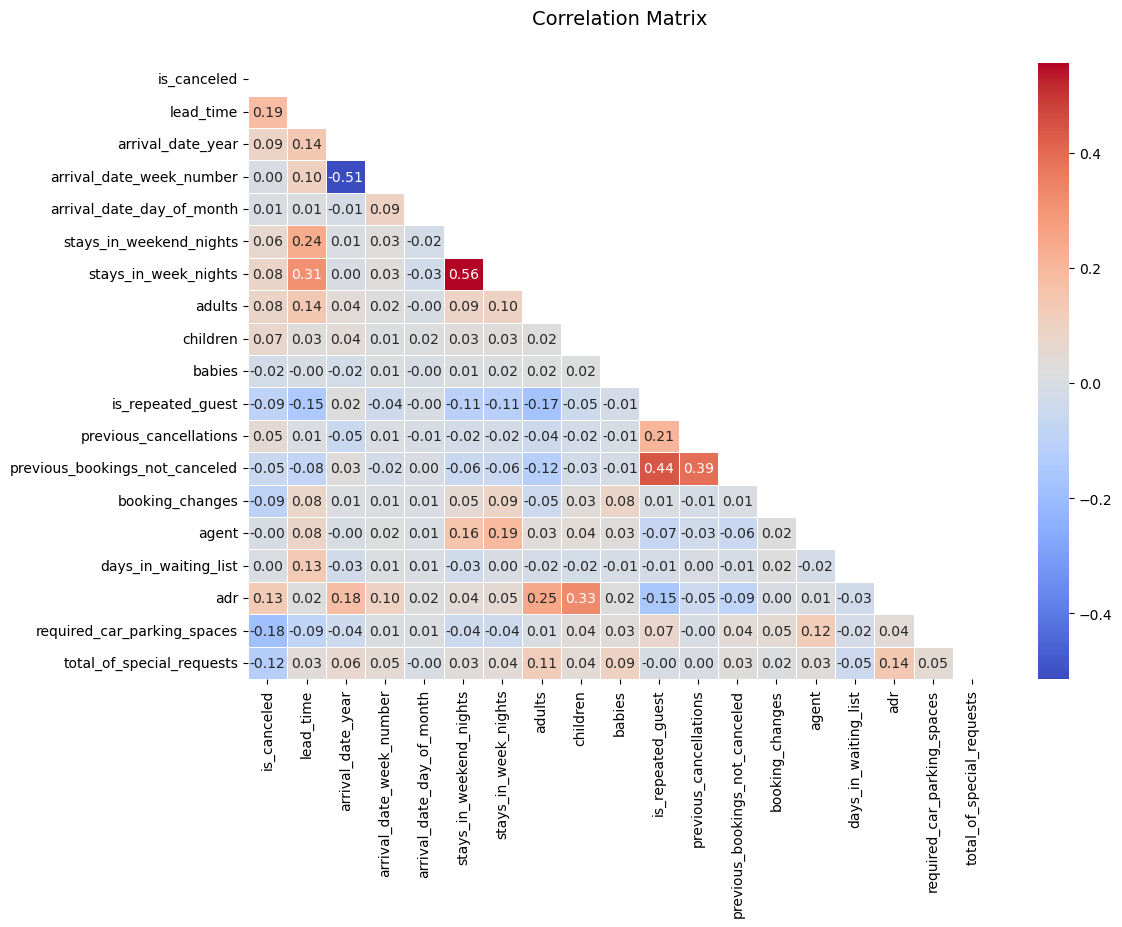

In [272]:
# Compute correlation matrix
corr_matrix = df.corr(numeric_only=True)

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

# Initialize the matplotlib figure
plt.figure(figsize=(12, 8))

# Plot correlation matrix
sns.heatmap(corr_matrix, mask=mask, cmap='coolwarm', annot=True, fmt=".2f", linewidths=.5)

plt.title('Correlation Matrix', fontsize=14, y=1.05)

plt.show()

#### Categorical
- Features `market_segment` and `distribution_channel` have a strong correlation due to overlapping subcategories

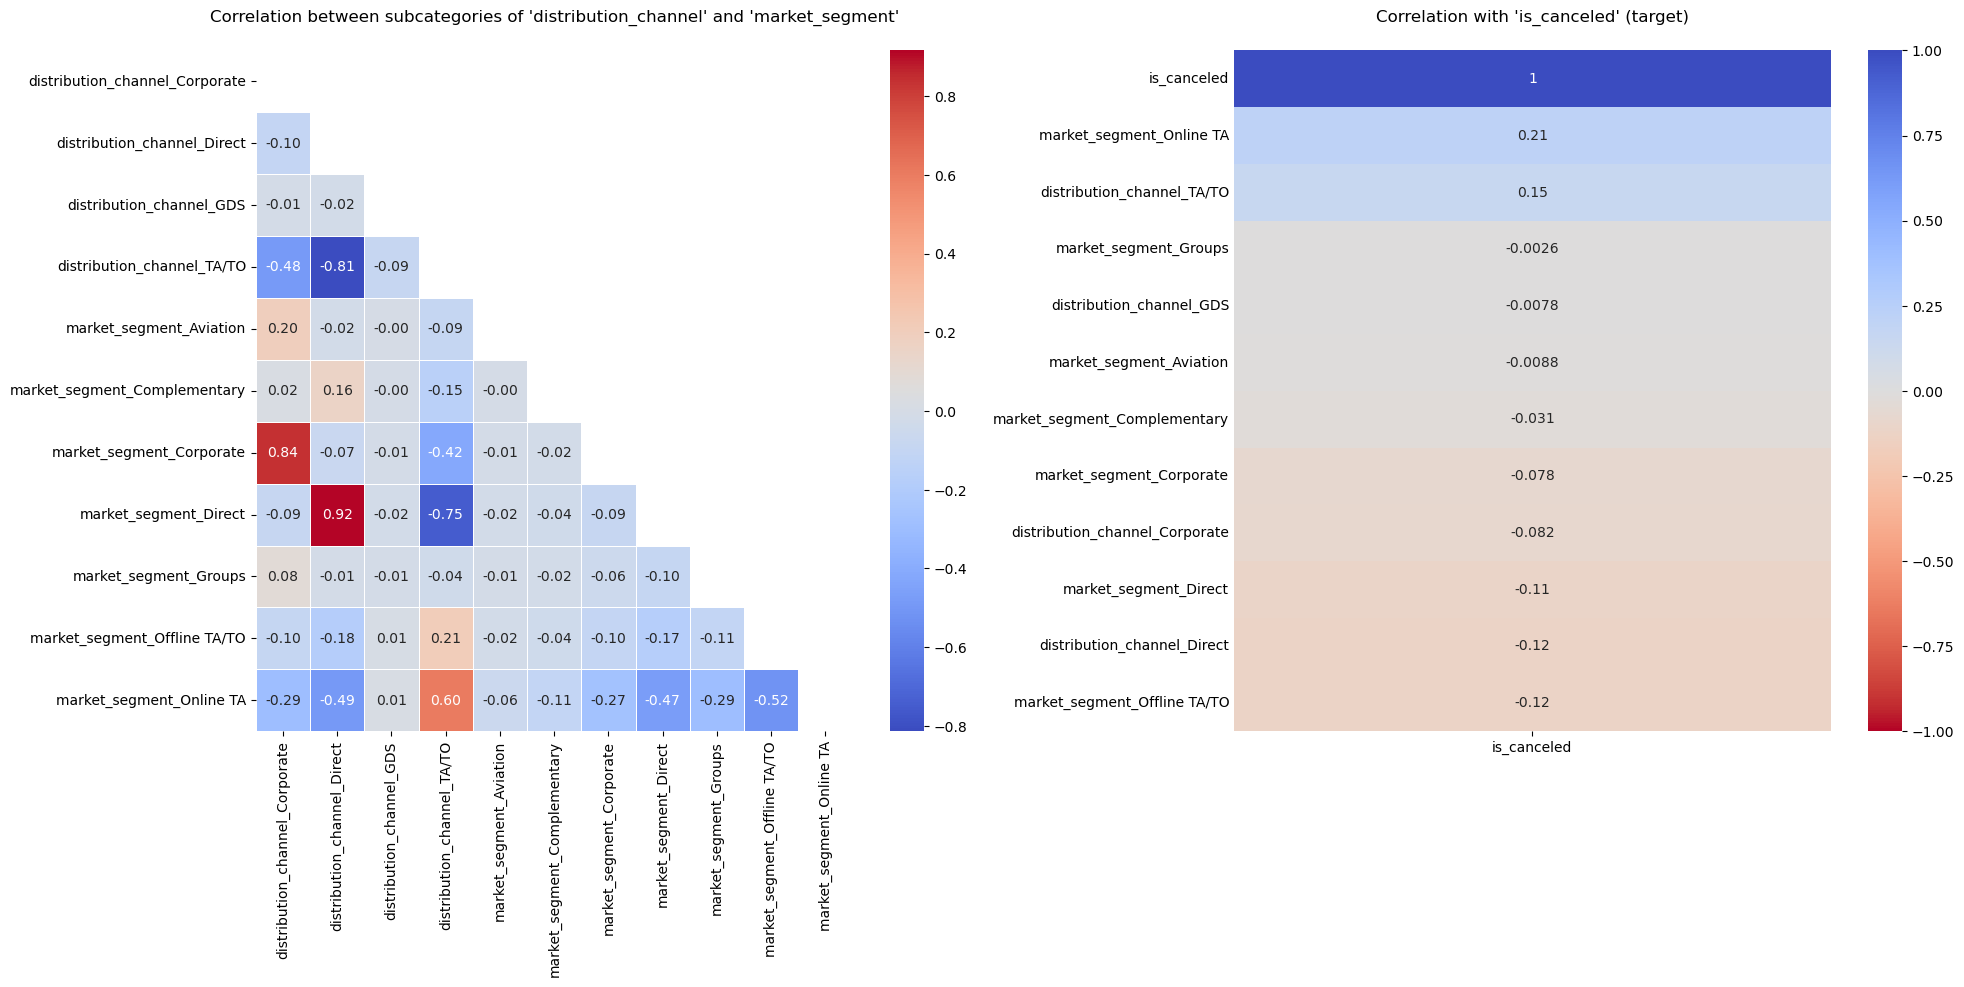

In [273]:
# Encode categorical variables for 'distribution_channel' and 'market_segment'
encoded_df = pd.get_dummies(df[['distribution_channel', 'market_segment']])

# Compute correlation matrix for the encoded features
corr_matrix = encoded_df.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

# Initialize the matplotlib figure with two subplots
fig, ax = plt.subplots(1, 2, figsize=(20, 10))

# Plot 1: Correlation between subcategories of 'distribution_channel' and 'market_segment'
sns.heatmap(corr_matrix, mask=mask, cmap='coolwarm', annot=True, fmt=".2f", linewidths=.5, ax=ax[0])
ax[0].set_title("Correlation between subcategories of 'distribution_channel' and 'market_segment'", y=1.03)

# Encode categorical variables again for correlation with target
# This step seems repetitive from the description, so ensure your DataFrame 'encoded_df' is ready before this step
encoded_df['is_canceled'] = df['is_canceled']

# Correlation Heatmap with target for the second plot
corr_with_target = encoded_df.corr()["is_canceled"].sort_values(ascending=False).to_frame()

# Plot 2: Correlation with is_canceled (target)
sns.heatmap(corr_with_target, annot=True, cmap="coolwarm_r", cbar=True, vmin=-1, vmax=1, center=0, ax=ax[1])
ax[1].set_title("Correlation with 'is_canceled' (target)", y=1.03)
ax[1].tick_params(axis='y', length=0)  # Remove ticks from y-axis

plt.tight_layout()
plt.show()


## Data Preparation

### Strategic Feature Reduction for Predictive Accuracy

During the data analysis, we have decided to drop the following columns for the reasons specified:

- `reservation_status`: This column can cause data leakage for our target variable `is_canceled`. The status `Check-Out` implies that the customer did not cancel, which directly reveals the target.

- `reservation_status_date`: Similarly to `reservation_status`, this column could cause data leakage since the date of status might imply cancellation or not.

- `arrival_date_year`: The year of arrival would indicate that the booking was not canceled if they have arrived, leading to potential data leakage.

- `arrival_date_week_number`: This is being dropped for the same reason as `arrival_date_year`; its presence might reveal whether a booking was canceled.

- `assigned_room_type`: The type of room assigned can hint at whether the customer arrived; thus, it may not be canceled. Since `reserved_room_type` is retained, it captures the necessary room type information without potential data leakage.

- `distribution_channel`: This feature is highly correlated with `market_segment`. To reduce multicollinearity and to keep the dataset more concise, we are retaining the feature that has more distinctive categories and a higher correlation with the target variable.

- `arrival_date_day_of_month`: The day of the month is less informative compared to the week number for patterns such as holidays, which may have a more pronounced effect and do not typically span over a month. Since the `arrival_date_week_number` is more granular and informative for such patterns, we retain it and drop the day of the month.

These decisions are aimed at creating a more robust dataset for predictive modeling, ensuring that our features are informative without causing data leakage and reducing multicollinearity where possible.


In [274]:
# Drop columns that could introduce data leakage or are redundant:
df = df.drop([
    'reservation_status',          # Excluded to prevent data leakage as it directly indicates cancellation status.
    'reservation_status_date',     # Removed to avoid data leakage; knowing the status date could reveal the outcome.
    'arrival_date_year',           # Dropped since the arrival year reveals they didn't cancel; not predictive for future bookings.
    'arrival_date_week_number',    # Removed as knowing the specific week of arrival implies the booking was not canceled.
    'assigned_room_type',          # Excluded to prevent potential data leakage; having an assigned room often means the guest arrived.
    'distribution_channel',        # Dropped due to high correlation with 'market_segment' and lesser predictive value.
    'arrival_date_day_of_month',   # Omitted as 'arrival_date_week_number' captures similar temporal information with more relevance for patterns like holiday effects.
], axis=1)

### Data Type Optimization
Below, we optimize the data types to enhance the performance of the upcoming modeling process.
To our surprise, the newcomer, PyArrow, emerging straight from Pandas 2, praised for its speed, did not outperform the regularly optimized Pandas types.
Speed comparisons were conducted using %%timeit on the upcoming GridSearch:

- Default dataset types
    - 1.83 s ± 11.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

- Pandas 2 PyArrow data types
    - 1.75 s ± 23.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

- Pandas 1: optimized data types
    - 1.61 s ± 13.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

Hence, the regular but optimized types were chosen.

In [275]:
float_features = [
    'adr'
]

int_features = [
    'is_canceled',
    'lead_time',
    'stays_in_weekend_nights',
    'stays_in_week_nights',
    'adults',
    'children',
    'babies',
    'is_repeated_guest',
    'previous_cancellations',
    'previous_bookings_not_canceled',
    'booking_changes',
    'required_car_parking_spaces',
    'total_of_special_requests',
    'days_in_waiting_list',
    'agent',
]

object_features = [
    'hotel',
    'arrival_date_month',
    'meal',
    'country',
    'market_segment',
    'reserved_room_type',
    'deposit_type',
    'customer_type'
]

# Optimize float columns
for col in float_features:
    df[col] = df[col].astype('float64')

# Optimize integer columns
for col in int_features:
    if col in ['lead_time', 'days_in_waiting_list', 'agent']:
        df[col] = df[col].astype('int16')
    else:
        df[col] = df[col].astype('int8')

# Optimize object columns
for col in object_features:
    df[col] = df[col].astype('category')

## Logistic Regression for Predictive Modeling

### Preprocessing & Model Strategy

- **Target Encoding**: Applied to 'country' to handle high cardinality; preserves target correlation, optimizes for dimensionality and computation.
- **Data Split**: 70% training, 15% validation, 15% testing; ensures integrity in model evaluation.
- **Standardization & One-Hot Encoding**: Numericals standardized; categoricals one-hot encoded.
- **Pipeline**: Integrates preprocessing with logistic regression for streamlined execution and to prevent data leakage.
- **Hyperparameter Tuning**: GridSearchCV optimizes logistic regression parameters for balance between performance and overfitting.
- **Threshold Adjustment**: CustomThresholdClassifier tailors the decision threshold, enhancing control over the trade-off between precision and recall to align with business objectives.
    - Below 0.5: Increases recall.
    - Above 0.5: Boosts precision.

Best params:
logisticregression__C: 1
logisticregression__penalty: l2
logisticregression__solver: lbfgs
logisticregression__tol: 0.0001

Precision with custom threshold on train data: 0.6858690744920993
Precision with custom threshold on validation data: 0.6687925170068028

Classification Report with custom threshold on training data: 
              precision    recall  f1-score   support

           0       0.82      0.92      0.87     44351
           1       0.69      0.45      0.54     16809

    accuracy                           0.79     61160
   macro avg       0.75      0.69      0.71     61160
weighted avg       0.78      0.79      0.78     61160

Classification Report with custom threshold on validation data: 
              precision    recall  f1-score   support

           0       0.81      0.92      0.86      9504
           1       0.67      0.44      0.53      3602

    accuracy                           0.79     13106
   macro avg       0.74      0.68      0.69     1310

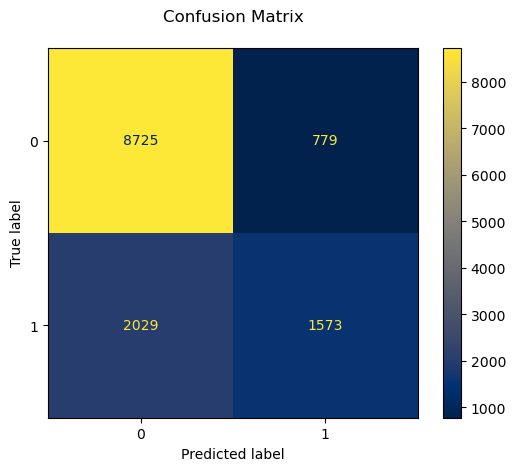

In [280]:
from category_encoders import TargetEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, precision_score
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.metrics import ConfusionMatrixDisplay

class CustomThresholdClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, base_estimator, threshold=0.5):
        self.base_estimator = base_estimator
        self.threshold = threshold
    
    def fit(self, X, y=None):
        self.base_estimator.fit(X, y)
        return self
    
    def predict(self, X):
        probabilities = self.base_estimator.predict_proba(X)[:, 1]
        return (probabilities >= self.threshold).astype(int)

# Define features and target variable
X = df.drop(columns=['is_canceled'])  # Exclude target variable
y = df['is_canceled']

# Split the data into training, validation and testing sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, train_size=0.7, stratify=y, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, train_size=0.5, stratify=y_temp, random_state=42)

# Initialize and fit the TargetEncoder on training data
target_encoder = TargetEncoder()
X_train['country'] = target_encoder.fit_transform(X_train['country'], y_train)
X_val['country'] = target_encoder.transform(X_val['country'])
X_test['country'] = target_encoder.transform(X_test['country'])

# Define transformers for numerical, 'agent', and categorical features
num_transformer = make_pipeline(StandardScaler())
cat_transformer = make_pipeline(OneHotEncoder(handle_unknown='error', drop='first'))

# Define column selectors for numerical and categorical features
num_features = make_column_selector(dtype_include='number')
cat_features = make_column_selector(dtype_include=['object', 'category'])

# Make the column transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_transformer, num_features),
        ('cat', cat_transformer, cat_features)
    ],
    verbose_feature_names_out=False  # This ensures the original feature names are maintained
)

# Instantiate the logistic regression model
log_reg_model = LogisticRegression(max_iter=1000)

# Create the pipeline
pipe = make_pipeline(preprocessor, log_reg_model)

# Define hyperparameter grid
param_grid = {
    'logisticregression__C': [1],             # Inverse of regularization strength; smaller values specify stronger regularization.
    'logisticregression__penalty': ['l2'],    # 'lbfgs' supports only 'l2', 'saga' supports both 'l1' and 'l2'
    'logisticregression__solver': ['lbfgs'],  # Solver
    'logisticregression__tol': [0.0001],      # Stopping criteria precision. Default: 0.0001.
}

# Perform CV hyperparameter search
grid_logreg = GridSearchCV(estimator=pipe,
                           param_grid=param_grid,
                           cv=5,
                           scoring='accuracy',
                           n_jobs=-1)

# Fit best estimator on training data
grid_logreg.fit(X_train, y_train)

# Extract the best logistic regression model from grid search
best_log_reg_model = grid_logreg.best_estimator_

# Wrap the best model with CustomThresholdClassifier, setting custom threshold
custom_threshold_classifier = CustomThresholdClassifier(base_estimator=best_log_reg_model, threshold=0.5)

# Fit the custom threshold classifier to the training data
custom_threshold_classifier.fit(X_train, y_train)

# Predict with the custom threshold classifier on the validation set
y_pred_val_custom_threshold = custom_threshold_classifier.predict(X_val)

# Print best parameters from the grid search
print("Best params:")
for key, value in grid_logreg.best_params_.items():
    print(f"{key}: {value}")

# Since we're using a custom threshold classifier, we'll evaluate it directly
# Predict with the custom threshold classifier on both training and validation sets
y_pred_train_custom_threshold = custom_threshold_classifier.predict(X_train)
y_pred_val_custom_threshold = custom_threshold_classifier.predict(X_val)

# Generate classification reports for both training and validation sets using the custom threshold predictions
class_report_train_custom = classification_report(y_train, y_pred_train_custom_threshold)
class_report_val_custom = classification_report(y_val, y_pred_val_custom_threshold)

# Calculate precision for both training and validation sets as an additional metric
precision_train_custom = precision_score(y_train, y_pred_train_custom_threshold)
precision_val_custom = precision_score(y_val, y_pred_val_custom_threshold)

# Print precision scores and classification reports
print(f"\nPrecision with custom threshold on train data: {precision_train_custom}")
print(f"Precision with custom threshold on validation data: {precision_val_custom}")

print(f"\nClassification Report with custom threshold on training data: \n{class_report_train_custom}")
print(f"Classification Report with custom threshold on validation data: \n{class_report_val_custom}")

# Confusion Matrix from estimator
ConfusionMatrixDisplay.from_estimator(custom_threshold_classifier, X_val, y_val, cmap='cividis')
plt.title('Confusion Matrix', y=1.05)

# Save the plot as an image file
#plt.savefig('cm_threshold_0.5.png')

# Show the plot
plt.show()

### Metrics and Initial Evaluation Summary
In our quest to develop the most profitable model, our focus hinges on optimizing for True Positives (TP) and minimizing False Positives (FP). Each TP, where we accurately predict a customer will cancel their booking, results in a gain of 1000 SEK due to the effectiveness of sending a special deal to retain the customer. Conversely, each FP, where we incorrectly predict a cancellation and unnecessarily send a special deal, incurs a loss of 500 SEK. We also need to maintain high recall to avoid excessive False Negatives (FN), as missing potential TPs directly impacts our primary profit source.

The confusion matrix below indicates 1,573 TP and 779 FP, resulting in a total profit of 1,183,500 SEK. However, the 2,029 FN represents significant missed profit potential.

This preliminary evaluation suggests a profitable scenario, yet emphasizes the need to enhance our model’s precision to further increase profitability by reducing the incidence of FPs and bolstering TPs.

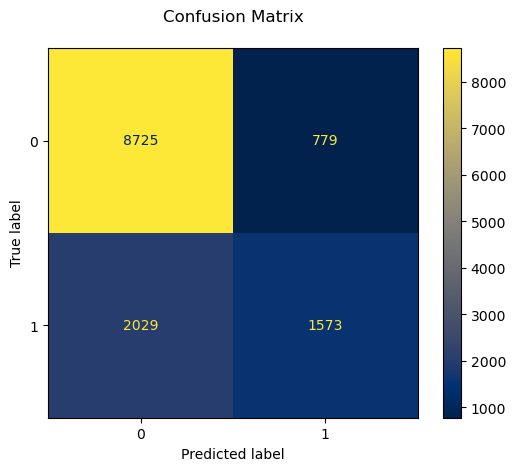

In [13]:
# Confusion Matrix from estimator
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(grid_logreg, X_val, y_val, cmap='cividis')
plt.title('Confusion Matrix', y=1.05)
plt.show()

#### Threshold Adjustment Insights

In our initial assessment, we focused on the default threshold of 0.5. Now, let's delve into the significance of adjusting this threshold.

As illustrated below, reducing the threshold increases true positives (TP) but also leads to a rise in false positives (FP). Conversely, raising the threshold decreases TP while reducing FP.

This observation carries practical implications. Consider a deployed model where false positives, such as sending unnecessary deals to guests, tarnish the company's reputation. By simply raising the threshold, we can mitigate this issue, albeit at the expense of sending fewer deals overall.

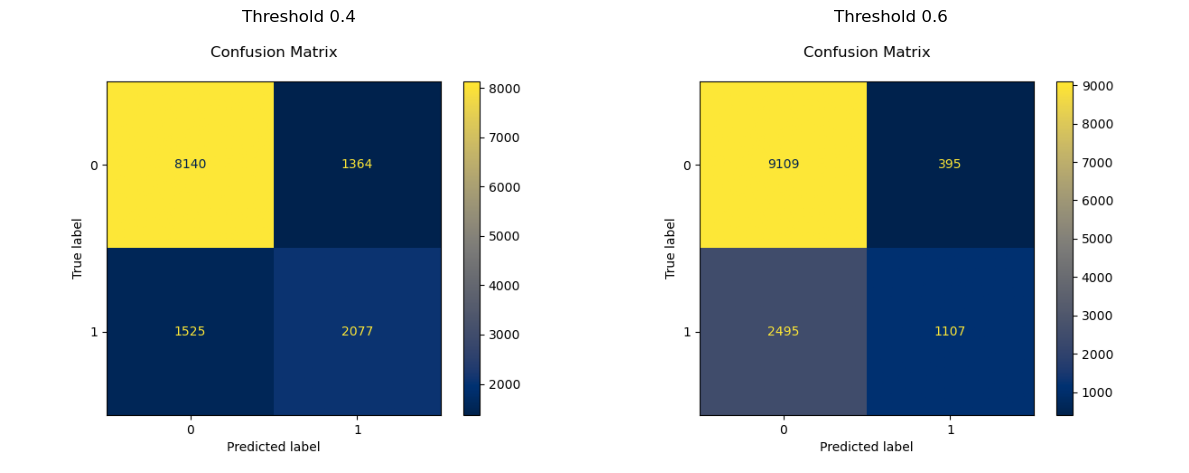

In [286]:
import os

# Path to the directory containing the PNG files
assets_dir = "assets"

# Create a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Plot the confusion matrix with threshold 0.4
ax = axes[0]
cm_threshold_0_4_path = os.path.join(assets_dir, "cm_threshold_0.4.png")
cm_threshold_0_4 = plt.imread(cm_threshold_0_4_path)
ax.imshow(cm_threshold_0_4)
ax.set_title('Threshold 0.4')
ax.axis('off')  # Remove ticks, spines, and labels

# Plot the confusion matrix with threshold 0.6
ax = axes[1]
cm_threshold_0_6_path = os.path.join(assets_dir, "cm_threshold_0.6.png")
cm_threshold_0_6 = plt.imread(cm_threshold_0_6_path)
ax.imshow(cm_threshold_0_6)
ax.set_title('Threshold 0.6')
ax.axis('off')  # Remove ticks, spines, and labels

# Adjust layout and show the plot
plt.tight_layout()
plt.show()


#### Understanding the ROC Curve
While this ROC curve may not conform to our typical expectations, lacking a distinct threshold selection point, it does reveal an intriguing trend. The relationship between true positives and false positives appears to follow a pattern akin to that of a function. However, for a more decisive evaluation, we will turn to a precision-recall curve when comparing models later on.

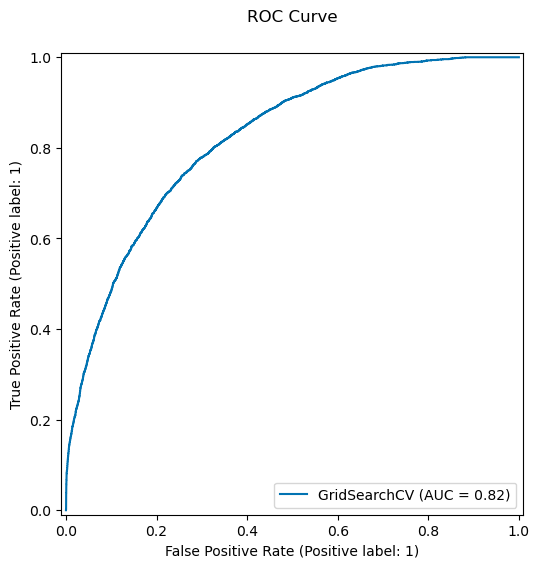

In [14]:
# Generate and plot ROC curve
from sklearn.metrics import RocCurveDisplay
fig, ax = plt.subplots(figsize=(8, 6))
RocCurveDisplay.from_estimator(grid_logreg, X_val, y_val, ax=ax)
plt.title('ROC Curve', y=1.05)
plt.show()

### Variance Inflation Factor (VIF) and Next Steps
Through our prior meticulous data cleaning and analysis efforts, we have identified and addressed features that could be problematic due to multicollinearity, data leakage, etc. As a result, the VIF score has been reduced to an acceptable level. Further pruning of features without any underlying motivation or insight could lead to a loss of predictive power. Therefore, the next step in our modeling process will involve deploying inferential modeling and statistical analysis to enable more targeted feature selection. This approach is aimed at exploring the balance between performance and interpretability in our model.

In [15]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Fit the preprocessor to the training data
preprocessor.fit(X_train)

# Transform the training data
X_train_transformed = preprocessor.transform(X_train)

# Convert transformed features into DataFrame
X_train_transformed_df = pd.DataFrame(X_train_transformed, columns=preprocessor.get_feature_names_out())  # .toarray()

# Sample a fraction of the data, e.g., 10%
sample_fraction = 0.1
X_train_transformed_df_sample = X_train_transformed_df.sample(frac=sample_fraction, random_state=42)

def calculate_vif(X):
    # Calculate VIF for each feature in a DataFrame
    return pd.DataFrame(
        {'feature': X.columns,
         'VIF': [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
        })

# Call the function and sort the results
vif_data = calculate_vif(X_train_transformed_df_sample)  # X_train.drop(columns=['const']
vif_data = vif_data.sort_values(by='VIF', ascending=False)
vif_data[:5]

,feature,VIF
37,market_segment_Online TA,24.186627
48,customer_type_Transient,23.191854
36,market_segment_Offline TA/TO,7.333084
34,market_segment_Direct,6.691198
49,customer_type_Transient-Party,5.017951


## Logistic Regression for Inferential Modeling
Leveraging `statsmodel.api`, we explore which variables significantly influence cancellations and assess logistic regression's overall performance. Logistic regression is preferable for interpretability, crucial for stakeholders. Although its $R^2$ is modest at 0.2579, indicating room for improved explanatory power, the model's precision at 0.69 demonstrates its practical value. We will delve deeper into the model's details and performance in the following sections.


### Model Performance Metrics
Our logistic regression model, while statistically significant, indicates some deficiencies:
- **$R^2$ (0.2579):** Suggests limited explanatory power.
- **Log-Likelihood Comparison:** The fitted model's log-likelihood is superior to the null model, but not markedly impressive.

Despite these limitations, we proceed with the model evaluation.

In [16]:
import statsmodels.api as sm

# Fit the preprocessor to the training data
preprocessor.fit(X_train)

# Transform the training and testing data
X_train_transformed = preprocessor.transform(X_train)
X_val_transformed = preprocessor.transform(X_val)
X_test_transformed = preprocessor.transform(X_test)

X_train_transformed_df = pd.DataFrame(X_train_transformed, columns=preprocessor.get_feature_names_out())  # .toarray()
X_val_transformed_df = pd.DataFrame(X_val_transformed, columns=preprocessor.get_feature_names_out())  # .toarray()
X_test_transformed_df = pd.DataFrame(X_test_transformed, columns=preprocessor.get_feature_names_out())    # .toarray()

# Add a constant term for the intercept for statsmodels
X_train_sm = sm.add_constant(X_train_transformed_df).reset_index(drop=True)
X_val_sm = sm.add_constant(X_test_transformed_df).reset_index(drop=True)
X_test_sm = sm.add_constant(X_test_transformed_df).reset_index(drop=True)

# Reset index for y_train
y_train = y_train.reset_index(drop=True)

# Create a Logit model
logit_model = sm.Logit(y_train, X_train_sm)

# Fit model without regularization
#result = sm.Logit(y_train, X_train_sm).fit(method='lbfgs', maxiter=10000)

# Fit model with 'lbfgs' solver
# result = logit_model.fit_regularized(method='l1', 
#                                      alpha=1.8,
#                                      maxiter=10000, 
#                                      solver='saga',
#                                      trim_mode='size',     # Enable manual trimming
#                                      size_trim_tol=0.01,   # Coefficients with an absolute value less than 0.01 will be set to zero
#                                      tol=1e-5              # Decrease tolerance to increase solver accuracy
#                                     )

# Fit model with coordinate descent as optimization algorithm with l1 regularization
result = logit_model.fit_regularized(method='l1', alpha=1.1, L1_wt=1, trim_mode='size', size_trim_tol=0.012, maxiter=10000)

# Print the summary of the model
print(result.summary())

# Calculate and print AIC and BIC
aic_no_z = result.aic  # Akaike Information Criterion
bic_no_z = result.bic  # Bayesian Information Criterion
print(f"\nAIC: {aic_no_z}")
print(f"BIC: {bic_no_z}")

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.43673577083973725
            Iterations: 665
            Function evaluations: 665
            Gradient evaluations: 665
                           Logit Regression Results                           
Dep. Variable:            is_canceled   No. Observations:                61160
Model:                          Logit   Df Residuals:                    61112
Method:                           MLE   Df Model:                           47
Date:                Sat, 16 Mar 2024   Pseudo R-squ.:                  0.2579
Time:                        13:32:32   Log-Likelihood:                -26686.
converged:                       True   LL-Null:                       -35963.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                     coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------

c:\Users\gusta\anaconda3\envs\goosewagon\Lib\site-packages\statsmodels\base\l1_solvers_common.py:71: ConvergenceWarning:

QC check did not pass for 3 out of 51 parameters
Try increasing solver accuracy or number of iterations, decreasing alpha, or switch solvers



### Coefficients and P-values: A Focused Analysis
Post hyperparameter tuning and thorough preprocessing, we examine the model's coefficients and their statistical significance. All variables hold some significance; however, not all subcategory encodings predict cancellation outcomes effectively, as shown by zero coefficients post-regularization (trimming threshold at 0.012):
- `reserved_room_type_H`
- `meal_FB`
- `arrival_date_month_February`

These findings highlight interpretability aspects and suggest these particular factors don't improve the predictive accuracy of our model. For example, bookings in February are not indicative of cancellations as those in peak vacation months might be. While these results merit further exploration, they also support the hypothesis that the higher cancellation rates may correlate with peak travel periods.


In [17]:
# Extract the summary as a dataframe
summary_df = pd.DataFrame(result.summary().tables[1].data)

# Assign the first row as the header
summary_df.columns = summary_df.iloc[0]
summary_df = summary_df.drop(0)

# Convert the 'coef' and 'P>|z|' columns to numeric, setting errors to 'coerce' which converts invalid parsing to NaN
summary_df['coef'] = pd.to_numeric(summary_df['coef'], errors='coerce')
summary_df['P>|z|'] = pd.to_numeric(summary_df['P>|z|'], errors='coerce')

# Replace NaN values with 0 in these columns
summary_df['coef'] = summary_df['coef'].fillna(0)
summary_df['P>|z|'] = summary_df['P>|z|'].fillna(0)

# Filter the dataframe for significant coefficients (p < 0.05)
significant_coefs_df = summary_df[summary_df['P>|z|'] < 0.05]

# Drop unnecessary columns
significant_coefs_df = significant_coefs_df[['', 'coef', 'P>|z|']].rename(columns={'': 'feature'})

significant_coefs_df.reset_index(drop=True, inplace=True)
significant_coefs_df = significant_coefs_df.sort_values(by="coef", ascending=False)

print('Variables with the strongest coefficients ')

# Display the most significant coefficients
pd.concat([significant_coefs_df.head(3), significant_coefs_df.tail(4)])


Variables with the strongest coefficients 


,feature,coef,P>|z|
37,deposit_type_Non Refund,3.1927,0.000
38,deposit_type_Refundable,0.8061,0.010
32,market_segment_Online TA,0.7240,0.001
16,total_of_special_requests,-0.5737,0.000
31,market_segment_Offline TA/TO,-0.8138,0.000
0,const,-2.7957,0.000
15,required_car_parking_spaces,-3.8478,0.000


### Analyzing Features with Higher Magnitude Coefficients
Below is a plot examining variables of particular interest to the model that exhibited stronger coefficients. Although these plots do not directly analyze the coefficients, they provide insights into the distribution of the target variable across the predictors, offering valuable perspectives for stakeholders:

- Bookings with non-refundable deposits are more likely to be canceled. This could be seen as positive for the business, but what does it imply for customer satisfaction?

- Bookings made through online travel agencies show a higher cancellation rate compared to others. Does this channel yield profit, or should we focus on other, more lucrative channels?

- A greater number of special requests and required car parking spaces indicate firmer bookings; they are less prone to cancellation.

Four coefficients with the most significant impact:
- deposit_type_Non Refund and deposit_type_Refundable
- market_segment_Online TA
- total_of_special_requests
- required_car_parking_spaces

As depicted by the normalized data, with classes shown as percentages, the strength of the coefficients aligns with the analysis of the target's proportion within the classes. Note that the bars are annotated with the total count to provide a scale of magnitude.

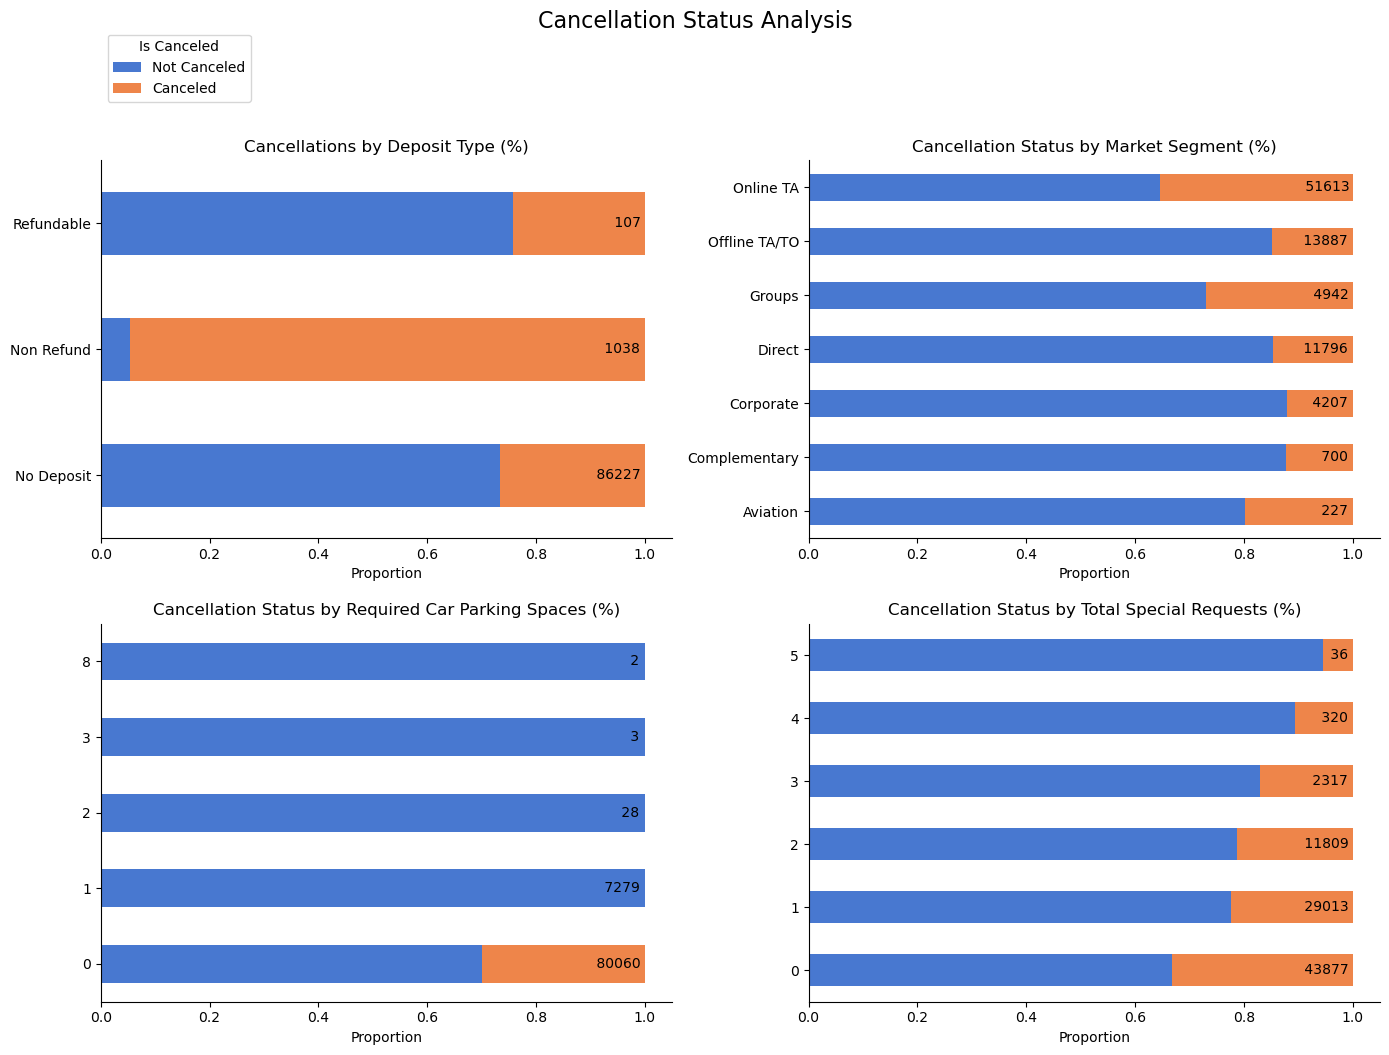

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Sample DataFrame
# df = pd.read_csv('your_dataset.csv')  # Assuming df is your DataFrame

# Define the palettes
palettes = ["muted", "muted", "muted", "muted"]

# Define the plot titles
plot_titles = [
    'Cancellations by Deposit Type (%)',
    'Cancellation Status by Market Segment (%)',
    'Cancellation Status by Required Car Parking Spaces (%)',
    'Cancellation Status by Total Special Requests (%)'
]

# Define the columns for each plot
columns = [
    ['deposit_type', 'is_canceled'],
    ['market_segment', 'is_canceled'],
    ['required_car_parking_spaces', 'is_canceled'],
    ['total_of_special_requests', 'is_canceled']
]

# Create subplots
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Cancellation Status Analysis', fontsize=16, y=1.05)  # Add a big title

for ax, palette, title, column in zip(axes.flatten(), palettes, plot_titles, columns):
    # Group the data and calculate proportions
    grouped_data = df.groupby(column).size().unstack(fill_value=0)
    totals = grouped_data.sum(axis=1)  # Total counts for each group
    proportions = grouped_data.div(totals, axis=0)  # Normalize to proportions
    
    # Plotting with normalized data
    sns.set_palette(palette)
    bars = proportions.plot(kind='barh', stacked=True, ax=ax)  # Use proportions for plotting
    
    # Annotation for total counts
    for i, (index, row) in enumerate(proportions.iterrows()):
        total = totals.loc[index]  # Get total count for the current group
        # Adjust x position by subtracting a small value to move text slightly to the left
        x_position = row.cumsum().values[-1] - (row.max() * 0.01)  # Adjust here as needed
        ax.text(x_position, i, f' {total}', va='center', ha='right')

    # Adjust plot aesthetics
    ax.set_title(title)
    ax.set_xlabel('Proportion')
    ax.set_ylabel('')
    
    # Add legend only to the first subplot
    if ax == axes.flatten()[0]:
        ax.legend(title='Is Canceled', labels=['Not Canceled', 'Canceled'], loc='upper left', bbox_to_anchor=(0, 1.35))
    else:
        # Remove legend from other subplots
        ax.get_legend().remove()
    
    sns.despine(ax=ax)

plt.tight_layout()
plt.subplots_adjust(top=0.9)  # Adjust top margin to make room for the big title
plt.show()

### Deviance Residual Analysis

Deviance residuals are instrumental in assessing the fit of a logistic regression model to individual observations. Here's a detailed analysis:

- **Range**: The residuals span from a minimum of -5.1059 to a maximum of 4.0692. This spread points to varied levels of predictive accuracy across observations.
- **Quartiles**: With the first quartile at -0.7116 and the third quartile at 0.5727, the model appears to fit a substantial proportion of the data well. The residuals' distribution around the median of -0.4053, however, is slightly skewed, hinting at possible model under-prediction for a number of cases.
- **Median**: The median deviance residual is negative (-0.4053), which could suggest a tendency for the model to under-predict the probability of the event occurring.
- **Outliers**: The range of the residuals indicates the presence of outliers, with some observations being poorly predicted by the model.

In conclusion, although the model demonstrates an adequate fit for many observations, the negative median and the presence of significant outliers warrant further examination. Investigating these outliers could uncover valuable insights, leading to model improvement.

In [19]:
# Extract deviance residuals from the fitted statsmodels object
deviance_residuals = result.resid_dev

# Calculate summary statistics for the deviance residuals
min_residual = np.min(deviance_residuals)
first_quartile = np.percentile(deviance_residuals, 25)
median_residual = np.median(deviance_residuals)
third_quartile = np.percentile(deviance_residuals, 75)
max_residual = np.max(deviance_residuals)

# Display summary statistics in R-like format
print(f"Deviance Residuals: \nMin: {min_residual:.4f}  1Q: {first_quartile:.4f} "
      f" Median: {median_residual:.4f}  3Q: {third_quartile:.4f}  Max: {max_residual:.4f}")

Deviance Residuals: 
Min: -5.1059  1Q: -0.7116  Median: -0.4053  3Q: 0.5727  Max: 4.0692


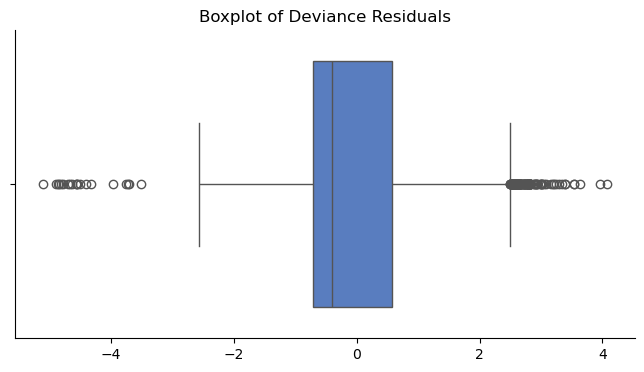

In [20]:
# Boxplot to identify outliers
plt.figure(figsize=(8, 4))
sns.boxplot(x=deviance_residuals)
plt.title('Boxplot of Deviance Residuals')
sns.despine()

#### Histogram of Deviance Residuals
This histogram reveals the logistic regression model's fit quality. Ideally, residuals should form a normal distribution around zero, showing model accuracy. The bimodal distribution here, with two peaks, implies the model's uneven performance across different observations. The dominant peak near zero reflects accurate predictions, whereas the secondary peak suggests systematic prediction errors. The higher left peak, with more negative residuals, may point to a tendency to overpredict the positive class. This pattern hints at model misspecification or incomplete data representation.

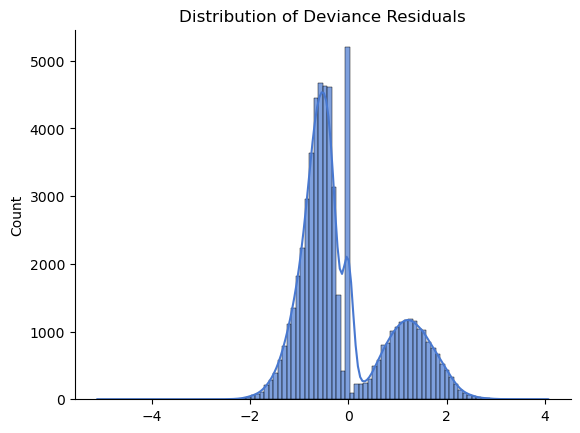

In [21]:
sns.histplot(data=deviance_residuals, kde=True, alpha=0.7, bins=100)
plt.title('Distribution of Deviance Residuals')
sns.despine()

#### Residuals vs. Fitted Values
The funnel-shaped spread of residuals points to non-constant variance, hinting at a potential logistic regression model misfit. Points clustered below zero for high fitted values reveal false positives, suggesting the model might not capture all complexities.

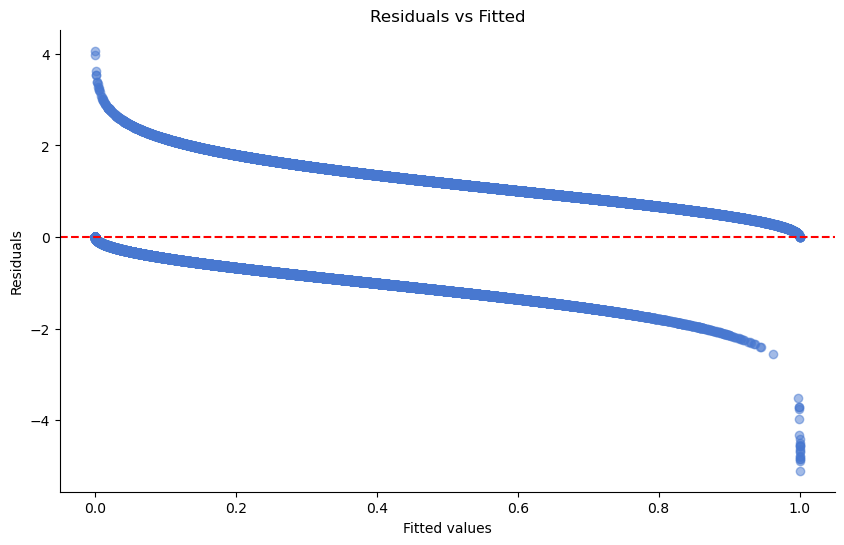

In [22]:
# Calculate deviance residuals
residuals = result.resid_dev

# Fitted values (probability scores)
fitted_vals = result.predict()

# Residual plot for fitted values vs. residuals without lowess smoothing for performance
plt.figure(figsize=(10, 6))
plt.scatter(x=fitted_vals, y=residuals, alpha=0.5)
plt.axhline(y=0, color='red', linestyle='--')
plt.title('Residuals vs Fitted')
plt.xlabel('Fitted values')
plt.ylabel('Residuals')
sns.despine()
plt.show()

## Random Forest Classifier

In [287]:
from sklearn.ensemble import RandomForestClassifier

# Define transformers for numerical and categorical features
num_transformer = make_pipeline(SimpleImputer(strategy='median'), StandardScaler())
cat_transformer = make_pipeline(OneHotEncoder(handle_unknown='ignore', drop='first'))

# Define column selectors for numerical and categorical features
num_features = make_column_selector(dtype_include='number')
cat_features = make_column_selector(dtype_include=object)

# Make the column transformer
preprocessor = make_column_transformer(
    (num_transformer, num_features),
    (cat_transformer, cat_features),
)

# Instantiate the random forest classifier model
rf_model = RandomForestClassifier()

# Create the pipeline
pipe = make_pipeline(preprocessor, rf_model)

# Fit the model
pipe.fit(X_train, y_train)

# Evaluate the model on test data
y_pred = pipe.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

#print(f"\nAccuracy on train data: {pipe.score(X_train, y_train)}")
#print(f"Accuracy on test data: {accuracy}")
print(f"\nClassification Report on test data: \n{class_report}")


Classification Report on test data: 
              precision    recall  f1-score   support

           0       0.86      0.91      0.88      9504
           1       0.72      0.61      0.66      3602

    accuracy                           0.83     13106
   macro avg       0.79      0.76      0.77     13106
weighted avg       0.82      0.83      0.82     13106



In [289]:
from prettytable import PrettyTable

def display_search_results(search_estimator, X_train=None, y_train=None, X_val=None, y_val=None):
    """
    Display hyperparameter tuning results and classification reports for training and validation datasets.

    Summarizes the results of hyperparameter tuning from a trained GridSearchCV 
    or RandomizedSearchCV for classification models. If training data (`X_train` and `y_train`)
    is provided, it displays the classification report for the training dataset. If validation data
    (`X_val` and `y_val`) is provided, it also displays the classification report for the validation dataset.

    Parameters
    ----------
    search_estimator : sklearn estimator
        Trained instance of GridSearchCV or RandomizedSearchCV.
    X_train : array-like, shape (n_samples, n_features), optional
        Training dataset to compute training metrics. Default is None.
    y_train : array-like, shape (n_samples, ), optional
        Actual labels for `X_train`. Used only if `X_train` is provided. Default is None.
    X_val : array-like, shape (n_samples, n_features), optional
        Validation dataset to compute additional metrics. Default is None.
    y_val : array-like, shape (n_samples, ), optional
        Actual labels for `X_val`. Used only if `X_val` is provided. Default is None.

    Returns
    -------
    None
        Outputs the tuning results and classification reports to the console.

    Notes
    -----
    Assumes `search_estimator` is a fit instance of GridSearchCV or RandomizedSearchCV.
    The model's name is extracted from `search_estimator` for the results table title.
    """
    
    # Extract the model name from the estimator
    model_name = search_estimator.estimator.steps[-1][1].__class__.__name__
    title = f"{model_name} Tuning Results"
    
    # PrettyTable display for tuning results
    myTable = PrettyTable(["Parameter", "Value"])
    
    if hasattr(search_estimator, 'best_params_'):
        for key, value in search_estimator.best_params_.items():
            myTable.add_row([key, value])
    else:
        myTable.add_row(["No parameters found", "N/A"])
        
    myTable.title = title
    print(myTable)

    # Display classification report for the training set if provided
    if X_train is not None and y_train is not None:
        y_train_pred = search_estimator.predict(X_train)
        print("Classification Report - Training Set:")
        print(classification_report(y_train, y_train_pred))
    
    # Display classification report for the validation set if provided
    if X_val is not None and y_val is not None:
        y_val_pred = search_estimator.predict(X_val)
        print("Classification Report - Validation Set:")
        print(classification_report(y_val, y_val_pred))

In [27]:
# from sklearn.model_selection import RandomizedSearchCV
# from scipy.stats import randint, uniform

# # Hyperparameter distributions for RandomForestRegressor using ranges
# param_distributions = {
#     'randomforestclassifier__max_depth': randint(8, 12),                # Sets the maximum depth of the trees, limiting how many splits it can make
#     'randomforestclassifier__max_features': ['sqrt'],           # Specifies the maximum number of features considered when looking for the best split
#     'randomforestclassifier__max_leaf_nodes': randint(35, 50),          # Limits the maximum number of leaf nodes, reducing overfitting by preventing the tree from growing too complex
#     'randomforestclassifier__min_samples_leaf': randint(1, 3),          # Requires at least this many samples to be at a leaf node, further preventing overfitting by ensuring a minimum number of samples at the leaves
#     'randomforestclassifier__min_samples_split': randint(2, 6),         # Sets the minimum number of samples required to split an internal node
#     'randomforestclassifier__n_estimators': randint(200, 400),          # Specifies the number of trees in the forest, affecting the model's performance and computational cost
#     'randomforestclassifier__max_samples': [0.6],           # Determines the fraction of the original dataset given to any individual tree, reducing training time
# }

# # Random search setup
# random_rf = RandomizedSearchCV(estimator=pipe,
#                                param_distributions=param_distributions,
#                                n_iter=100,
#                                cv=5,
#                                scoring="accuracy",
#                                n_jobs=-1,
#                                random_state=42)  # For reproducibility

# # Fit model to data
# random_rf.fit(X_train, y_train)

# # Show best params and scores
# display_search_results(random_rf, X_train, y_train, X_val, y_val)


```python
+---------------------------------------------------+
|       RandomForestClassifier Tuning Results       |
+-------------------------------------------+-------+
|                 Parameter                 | Value |
+-------------------------------------------+-------+
|     randomforestclassifier__max_depth     |   11  |
|    randomforestclassifier__max_features   |  sqrt |
|   randomforestclassifier__max_leaf_nodes  |   47  |
|    randomforestclassifier__max_samples    |  0.6  |
|  randomforestclassifier__min_samples_leaf |   1   |
| randomforestclassifier__min_samples_split |   2   |
|    randomforestclassifier__n_estimators   |  214  |
+-------------------------------------------+-------+
```

+---------------------------------------------------+
|       RandomForestClassifier Tuning Results       |
+-------------------------------------------+-------+
|                 Parameter                 | Value |
+-------------------------------------------+-------+
|     randomforestclassifier__max_depth     |   12  |
|    randomforestclassifier__max_features   |  sqrt |
|   randomforestclassifier__max_leaf_nodes  |   47  |
|    randomforestclassifier__max_samples    |  0.8  |
|  randomforestclassifier__min_samples_leaf |   2   |
| randomforestclassifier__min_samples_split |   3   |
|    randomforestclassifier__n_estimators   |  400  |
+-------------------------------------------+-------+
Classification Report - Training Set:
              precision    recall  f1-score   support

           0       0.82      0.94      0.88     44351
           1       0.74      0.47      0.57     16809

    accuracy                           0.81     61160
   macro avg       0.78      0.70      0.7

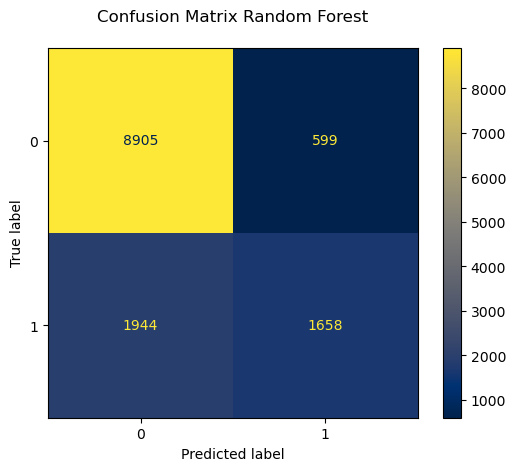

In [291]:
# Hyperparameter grid for RandomForestRegressor
param_grid = {
    'randomforestclassifier__max_depth': [12],        # Sets the maximum depth of the trees, limiting how many splits it can make
    'randomforestclassifier__max_features': ['sqrt'], # Specifies the maximum number of features considered when looking for the best split
    'randomforestclassifier__max_leaf_nodes': [47],   # Limits the maximum number of leaf nodes, reducing overfitting by preventing the tree from growing too complex
    'randomforestclassifier__max_samples': [0.8],     # Determines the fraction of the original dataset given to any individual tree, reducing training time
    'randomforestclassifier__min_samples_leaf': [2],  # Requires at least this many samples to be at a leaf node, further preventing overfitting by ensuring a minimum number of samples at the leaves
    'randomforestclassifier__min_samples_split': [3], # Sets the minimum number of samples required to split an internal node
    'randomforestclassifier__n_estimators': [400],    # Specifies the number of trees in the forest, affecting the model's performance and computational cost

}

# Grid search setup
grid_rf = GridSearchCV(estimator=pipe,
                      param_grid=param_grid,
                      cv=5,
                      scoring="f1",
                      n_jobs=-1)

# Fit model to data
grid_rf.fit(X_train, y_train)

# Show best params and scores
display_search_results(grid_rf, X_train, y_train, X_val, y_val)

# Confusion Matrix from estimator
ConfusionMatrixDisplay.from_estimator(grid_rf, X_val, y_val, cmap='cividis')
plt.title('Confusion Matrix Random Forest', y=1.05)
plt.show()

## Logistic Regression vs Random Forest
As we conclude our study on predicting hotel cancellations, we will conduct a final assessment by comparing the performance of Logistic Regression and Random Forest models on the test data.

### Precision-Recall Curve Analysis

Upon examining the Precision-Recall curves for the Random Forest (RF) and Logistic Regression (LogReg) models, we note a distinct advantage of the RF model. It achieves a higher recall score for the same precision compared to LogReg.

To illustrate, at a precision of 0.6, RF demonstrates a recall of approximately 0.8, whereas LogReg achieves a recall of around 0.6 at the same precision level.

In practical terms, this implies that the RF model captures more opportunities to send out special offers to guests while minimizing the risk of false positives—sending offers to individuals who do not require them.

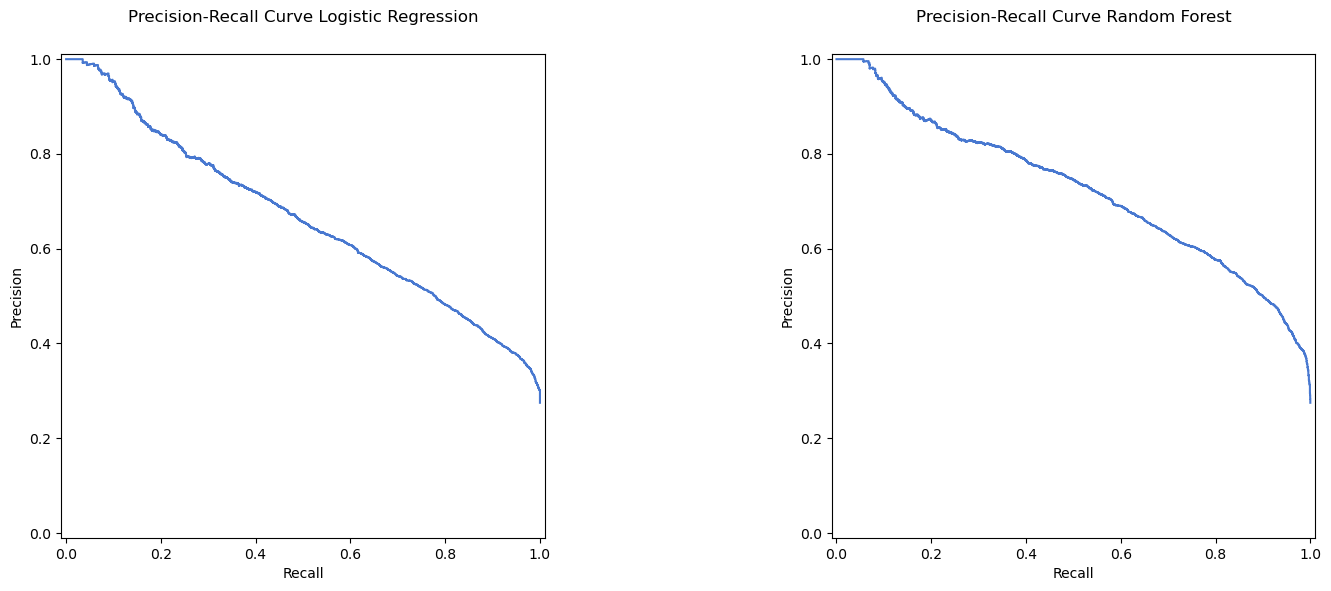

In [35]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import precision_recall_curve, PrecisionRecallDisplay

# Setup the subplot configuration
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))

# Predict probabilities for Logistic Regression
y_scores_logreg = grid_logreg.predict_proba(X_test)[:, 1]
# Generate precision-recall data for Logistic Regression
precision_logreg, recall_logreg, _ = precision_recall_curve(y_test, y_scores_logreg)
# Plot the Precision-Recall curve for Logistic Regression
PrecisionRecallDisplay(precision=precision_logreg, recall=recall_logreg).plot(ax=axes[0])
axes[0].set_title('Precision-Recall Curve Logistic Regression', y=1.05)

# Predict probabilities for Random Forest
y_scores_rf = grid_rf.predict_proba(X_test)[:, 1]
# Generate precision-recall data for Random Forest
precision_rf, recall_rf, _ = precision_recall_curve(y_test, y_scores_rf)
# Plot the Precision-Recall curve for Random Forest
PrecisionRecallDisplay(precision=precision_rf, recall=recall_rf).plot(ax=axes[1])
axes[1].set_title('Precision-Recall Curve Random Forest', y=1.05)

# Adjust layout and remove spines
plt.tight_layout()

# Display the plot
plt.show()

### Balancing Profit and Interpretability

In the context of a scenario where a true positive (TP) yields a 1000 SEK profit and a false positive (FP) incurs a 500 SEK loss, the Random Forest model outperforms the Logistic Regression model in terms of total profit.

- Random Forest: 1,357,500 SEK total profit (1662 TP, 609 FP)
- Logistic Regression: 1,254,500 SEK total profit (1620 TP, 731 FP)

The Random Forest model strikes a better balance between identifying potential cancellations and minimizing false positives, resulting in higher overall profit and a lower risk of negative impact on reputation.

However, when considering the importance of interpretability and application flexibility in real-world scenarios, the Logistic Regression model offers notable advantages:
- It allows for quick adjustment of the threshold to mitigate false positives in response to customer complaints.
- The model's interpretability facilitates tracking of coefficient significance changes, providing insights for model improvement and business pattern analysis.

Therefore, while Random Forest excels in maximizing profit, Logistic Regression stands out for its interpretability and application flexibility, making it a valuable choice in certain contexts where these factors are prioritized.


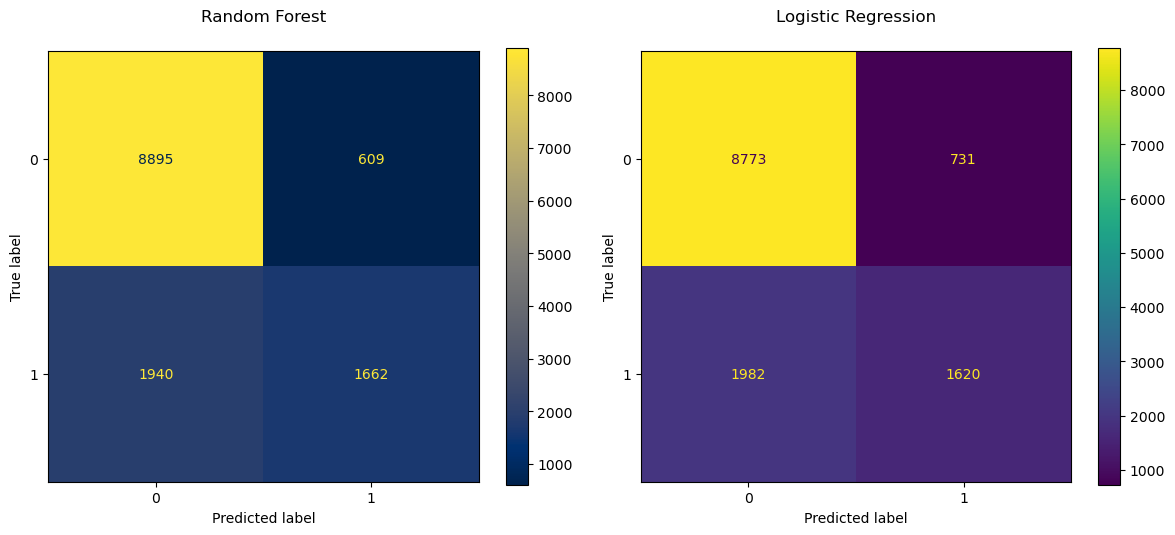

In [298]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Confusion Matrix for Random Forest
ConfusionMatrixDisplay.from_estimator(grid_rf, X_test, y_test, cmap='cividis', ax=ax1)
ax1.set_title('Random Forest', y=1.05)

# Confusion Matrix for Logistic Regression
ConfusionMatrixDisplay.from_estimator(grid_logreg, X_test, y_test, cmap='viridis', ax=ax2)
ax2.set_title('Logistic Regression', y=1.05)

plt.tight_layout()
plt.show()

# BONUS CHALLENGE 1!

- Try out building your own scoring function that you pass to the scoring parameter in the GridSearchCV object!

*Check out scikit-learns `make_scorer()` method*

# BONUS CHALLENGE 2!

- Instead of a LogReg model, use a RandomForestClassifier model!

Which model had the best performance? Was there a big difference?
